In [1]:
import numpy as np
from scipy.stats import special_ortho_group
import jax.numpy as jnp
from jax import grad, vmap
from Mondrian_forest import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import pickle

dim_in = 5
active = 2
def simulate_y(x, rotation, seed = 0, noise_sig2 = 0.01):
    res = jnp.dot(x, rotation)
    res = (res ** 2) * -0.25
    res = jnp.exp(res)
    projected = jnp.concatenate([jnp.ones(active), jnp.zeros(dim_in - active)])
    y = 5 * jnp.max(res * projected, axis = 1)
    r_noise = np.random.RandomState(seed)
    #n = len(x)
    noise = r_noise.randn(1)[0] * jnp.sqrt(noise_sig2)
    y = y + noise
    return y


n = 2000
n_test = 1000
tries = 10


x_train, _, x_test, _, _ = pickle.load(open('axis_aligned_data.pickle', 'rb'))

x_train = x_train[:, :dim_in]
x_test = x_test[:, :dim_in]

rotation = special_ortho_group.rvs(dim_in)

y_train = simulate_y(x_train, rotation)

y_test = simulate_y(x_test, rotation)

sample_range = [100, 200, 400, 800, 1600]

M = 10                      # number of Mondrian trees to use
delta = 0                   # ridge regression delta

rotation

array([[-0.16370632,  0.40805089, -0.32173482, -0.50227214,  0.67149394],
       [-0.3867152 ,  0.64458699, -0.27246699,  0.0218228 , -0.60020369],
       [ 0.02218065,  0.55251443,  0.64366475,  0.43396669,  0.30266223],
       [ 0.34302326,  0.10401922, -0.63635574,  0.6521048 ,  0.20328734],
       [-0.83993729, -0.3192333 , -0.0547312 ,  0.36562098,  0.23647672]])

In [2]:
def simulate_y(x, rotation, seed = 0, noise_sig2 = 0.01):
    res = jnp.dot(x, rotation)
    res = (res ** 2) * -0.25
    res = jnp.exp(res)
    projected = jnp.concatenate([jnp.ones(active), jnp.zeros(dim_in - active)])
    y = 5 * jnp.max(res * projected)
    r_noise = np.random.RandomState(seed)
    #n = len(x)
    noise = r_noise.randn(1)[0] * jnp.sqrt(noise_sig2)
    y = y + noise
    return y
W_grad = vmap(grad(simulate_y, argnums=0), in_axes=(0, None), out_axes=0)(x_test, rotation)
from numpy import linalg
true_H = jnp.matmul(jnp.transpose(W_grad), W_grad) / n_test
norm_H = linalg.norm(true_H, ord = 2)

In [3]:
np.set_printoptions(precision=5, suppress=True)
true_H/two_one_norm(true_H)

Array([[ 0.317  ,  0.53662,  0.36099, -0.02687,  0.02291],
       [ 0.53662,  0.93238,  0.56539, -0.11757,  0.22014],
       [ 0.36099,  0.56539,  0.49804,  0.10661, -0.31912],
       [-0.02687, -0.11757,  0.10661,  0.21878, -0.54663],
       [ 0.02291,  0.22014, -0.31912, -0.54663,  1.37205]], dtype=float32)

In [4]:
np.linalg.matrix_rank(true_H)

2

# Save training history

In [5]:
lifetime = 5

stats = []
for i in range(len(sample_range)):
    n_sim = sample_range[i]
    dist = {'n': n_sim, 'history': []}
    for trial in tqdm(range(tries)):
        history, w_trees = train(
            x_train[:n_sim, ], y_train[:n_sim, ], M, lifetime, delta
        )
        dist['history'].append([history, w_trees])
    stats.append(dist)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


# Get H estimate

In [6]:
from estimate_H import *
raw_H_estimates = get_H_estimates(stats, x_train, y_train, M, sample_range, tries = 10)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:26<00:00,  8.62s/it]


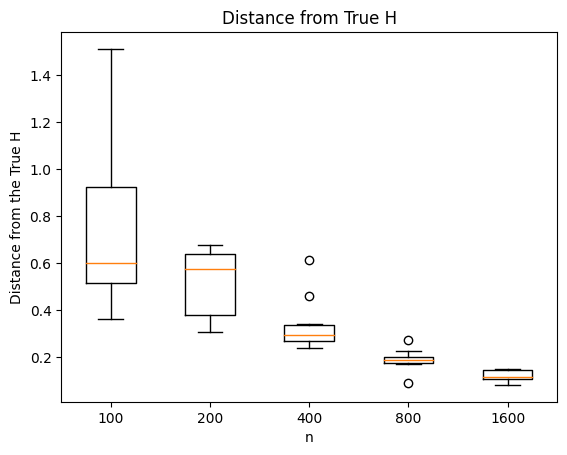

In [7]:
from util import *
np.set_printoptions(precision=4)
plot_H_estimates(raw_H_estimates, true_H, get_angle_distance, sample_range, active, dim_in)

In [8]:
lifetime_max = 5
n_sim = 1600
results = []
results.append(
    evaluate_all_lifetimes(x_train[:n_sim,], 
                           y_train[:n_sim], 
                           x_test, y_test, M, lifetime_max, delta))

In [9]:
x_train_transformed, x_test_transformed = transform_data(true_H/two_one_norm(true_H), x_train, x_test)
results.append(
    evaluate_all_lifetimes(x_train_transformed[:n_sim, ], 
                           y_train[:n_sim], 
                           x_test_transformed, y_test, M, lifetime_max, delta))

In [10]:
H_1 = raw_H_estimates[4]['H'][0]/two_one_norm(raw_H_estimates[4]['H'][0])

x_train_transformed, x_test_transformed = transform_data(H_1, x_train, x_test)
results.append(
    evaluate_all_lifetimes(x_train_transformed[:n_sim, ], 
                           y_train[:n_sim], 
                           x_test_transformed, y_test, M, lifetime_max, delta))

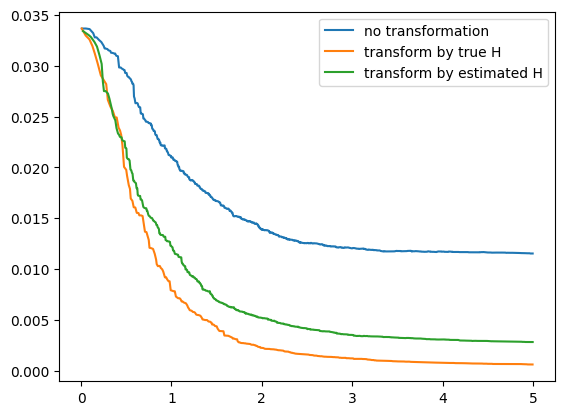

In [11]:
plt.plot(results[0][0]['times'], results[0][0]['mse'], label = 'no transformation')
plt.plot(results[1][0]['times'], results[1][0]['mse'], label = 'transform by true H')
plt.plot(results[2][0]['times'], results[2][0]['mse'], label = 'transform by estimated H')
plt.legend()

In [12]:
raw_H_estimates[4]['H'][0]

array([[ 0.0868,  0.0525,  0.0409, -0.003 ,  0.008 ],
       [ 0.0525,  0.1225,  0.0515, -0.0043,  0.0197],
       [ 0.0409,  0.0515,  0.1081,  0.0074, -0.0205],
       [-0.003 , -0.0043,  0.0074,  0.0759, -0.0483],
       [ 0.008 ,  0.0197, -0.0205, -0.0483,  0.1681]], dtype=float32)

In [13]:
H_1

array([[ 0.6675,  0.4035,  0.3146, -0.0231,  0.0616],
       [ 0.4035,  0.9418,  0.3961, -0.0329,  0.1514],
       [ 0.3146,  0.3961,  0.831 ,  0.0569, -0.158 ],
       [-0.0231, -0.0329,  0.0569,  0.5835, -0.3715],
       [ 0.0616,  0.1514, -0.158 , -0.3715,  1.2931]], dtype=float32)

In [14]:
true_H/two_one_norm(true_H)

Array([[ 0.317 ,  0.5366,  0.361 , -0.0269,  0.0229],
       [ 0.5366,  0.9324,  0.5654, -0.1176,  0.2201],
       [ 0.361 ,  0.5654,  0.498 ,  0.1066, -0.3191],
       [-0.0269, -0.1176,  0.1066,  0.2188, -0.5466],
       [ 0.0229,  0.2201, -0.3191, -0.5466,  1.3721]], dtype=float32)

In [15]:
lifetime = 5

stats = []
for i in range(len(sample_range)):
    n_sim = sample_range[i]
    dist = {'n': n_sim, 'history': []}
    for trial in tqdm(range(tries)):
        history, w_trees = train(
            x_train_transformed[:n_sim, ], y_train[:n_sim, ], M, lifetime, delta
        )
        dist['history'].append([history, w_trees])
    stats.append(dist)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


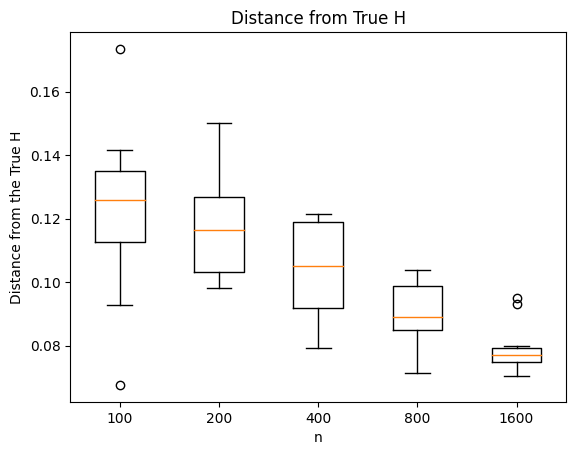

In [20]:
raw_H_estimates = get_H_estimates(stats, x_train_transformed, y_train, M, sample_range, tries = 10)
def get_angle_distance_1(H, truth, active, dim_in):
    return get_angle_distance(np.matmul(H_1, H), truth, active, dim_in)

plot_H_estimates(raw_H_estimates, true_H, get_angle_distance_1, sample_range, active, dim_in)

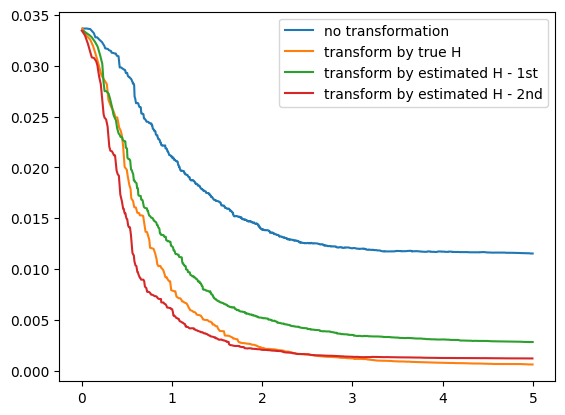

In [17]:
H_2 = raw_H_estimates[4]['H'][0]/two_one_norm(raw_H_estimates[4]['H'][0])

x_train_transformed, x_test_transformed = transform_data(H_2, x_train_transformed, x_test_transformed)
results.append(
    evaluate_all_lifetimes(x_train_transformed[:n_sim, ], 
                           y_train[:n_sim], 
                           x_test_transformed, y_test, M, lifetime_max, delta))

plt.plot(results[0][0]['times'], results[0][0]['mse'], label = 'no transformation')
plt.plot(results[1][0]['times'], results[1][0]['mse'], label = 'transform by true H')
plt.plot(results[2][0]['times'], results[2][0]['mse'], label = 'transform by estimated H - 1st')
plt.plot(results[3][0]['times'], results[3][0]['mse'], label = 'transform by estimated H - 2nd')
plt.legend()